In [2]:
from astroquery.gaia import Gaia
import warnings

# Comment this out if you want to see warnings
warnings.filterwarnings('ignore')
import astropy
import requests
import pyvo as vo
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import os
import requests
import sys
sys.path.append("../gaia_tools/")
import data_analysis
import covariance_generation as cov
from import_functions import import_data

In [ ]:
# Original sample
gaia_path = "/hdfs/local/sven/gaia_tools_data/gaia_rv_data_bayes.csv"
icrs_data = import_data(path = gaia_path, is_bayes = True, debug = False)

In [3]:
tmass_data_path = '/hdfs/local/sven/gaia_tools_data/crossmatched_tmass_data/crossmatched_tmass_data.csv'
crossmatched_tmass_data = pd.read_csv(tmass_data_path)

In [ ]:
merged_data = icrs_data.merge(crossmatched_tmass_data, on='source_id', suffixes=('_gaia', '_tmass'))

In [4]:
crossmatched_tmass_data.columns

Index(['source_id', 'tmass_oid', 'j_m', 'j_msigcom', 'h_m', 'h_msigcom', 'k_m',
       'k_msigcom', 'ph_qual', 'ra', 'dec'],
      dtype='object')

### Color range cut

In [37]:
crossmatched_tmass_data[((crossmatched_tmass_data.j_m - crossmatched_tmass_data.k_m) > 0.5) & ((crossmatched_tmass_data.j_m - crossmatched_tmass_data.k_m) < 1.1)]

,source_id,tmass_oid,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,ra,dec
1,4103049637327213440,241150495,13.272,0.061,12.406,0.058,12.202,0.047,AAA,278.887634,-15.350745
3,5966712023814100736,129939629,13.955,0.057,13.366,0.052,13.199,0.070,AAA,255.893129,-41.563683
4,2198292118993038464,444733779,12.377,0.023,11.821,0.033,11.567,0.029,EAA,331.084788,56.898933
6,5959019801816582272,128648517,13.486,0.072,12.783,0.080,12.572,0.069,AAA,263.928046,-41.875877
8,5977687963063223552,152022011,10.571,NaN,13.021,0.378,9.780,NaN,UDU,253.930088,-36.220665
...,...,...,...,...,...,...,...,...,...,...,...
7070726,5999456197349672832,112720440,9.601,0.128,8.746,0.170,8.668,0.160,BCC,232.247347,-45.657715
7070727,6019186143235920256,146392761,13.801,0.036,13.088,0.047,12.865,0.035,AAA,250.151587,-37.572754
7070728,5939029580905945600,105682320,10.929,NaN,12.812,0.044,9.896,NaN,UAU,255.627883,-47.283653
7070732,5959713078252724352,128647803,10.954,NaN,12.630,3.261,10.070,NaN,UEU,259.808764,-41.876038


### Uncertainty cut

In [10]:
crossmatched_tmass_data[(crossmatched_tmass_data.j_msigcom) < 0.1]
crossmatched_tmass_data[(crossmatched_tmass_data.h_msigcom) < 0.1]
crossmatched_tmass_data[(crossmatched_tmass_data.k_msigcom) < 0.1]

,source_id,tmass_oid,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,ra,dec
0,5933266834310007808,81136862,11.291,NaN,10.382,0.021,9.657,0.020,UAE,242.471135,-52.806522
1,4103049637327213440,241150495,13.272,0.061,12.406,0.058,12.202,0.047,AAA,278.887634,-15.350745
2,5951114420631264640,107816663,14.024,0.042,13.609,0.077,13.535,0.053,AAA,260.140017,-46.794502
3,5966712023814100736,129939629,13.955,0.057,13.366,0.052,13.199,0.070,AAA,255.893129,-41.563683
4,2198292118993038464,444733779,12.377,0.023,11.821,0.033,11.567,0.029,EAA,331.084788,56.898933
...,...,...,...,...,...,...,...,...,...,...,...
7070720,2251311188142608000,465172489,11.670,NaN,12.929,0.034,12.847,0.040,UAA,301.144456,70.007607
7070723,4296894160078561280,312689133,11.830,NaN,11.381,NaN,13.454,0.081,UUA,298.560119,6.421700
7070725,2028915440803837312,374402011,10.221,NaN,9.499,NaN,11.140,0.015,UUA,301.268399,27.920366
7070727,6019186143235920256,146392761,13.801,0.036,13.088,0.047,12.865,0.035,AAA,250.151587,-37.572754


### Photometric quality flag cut

In [32]:
import re
def is_allowed_flg(string):

    charRe = re.compile(r'[^A-B]')
    string = charRe.search(string)
    return not bool(string)

crossmatched_tmass_data.apply(lambda row : is_allowed_flg(row.ph_qual), axis=1)


0          False
1           True
2           True
3           True
4          False
           ...  
7070732    False
7070733    False
7070734    False
7070735    False
7070736    False
Length: 7070737, dtype: bool

In [34]:
crossmatched_tmass_data[crossmatched_tmass_data.apply(lambda row : is_allowed_flg(row.ph_qual), axis=1) == True]

,source_id,tmass_oid,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,ra,dec
1,4103049637327213440,241150495,13.272,0.061,12.406,0.058,12.202,0.047,AAA,278.887634,-15.350745
2,5951114420631264640,107816663,14.024,0.042,13.609,0.077,13.535,0.053,AAA,260.140017,-46.794502
3,5966712023814100736,129939629,13.955,0.057,13.366,0.052,13.199,0.070,AAA,255.893129,-41.563683
5,4058210969029372928,176035046,11.704,0.028,10.366,0.059,9.819,0.034,AAA,262.051947,-30.762695
6,5959019801816582272,128648517,13.486,0.072,12.783,0.080,12.572,0.069,AAA,263.928046,-41.875877
...,...,...,...,...,...,...,...,...,...,...,...
7070711,6077622510498751616,75876706,11.029,0.024,10.357,0.023,10.186,0.024,AAA,187.983636,-53.919159
7070713,4094614738213555072,227283007,11.721,0.043,10.419,0.038,9.874,0.026,AAA,274.933256,-18.945894
7070717,4154757199609510912,257316208,11.538,0.037,9.221,0.124,8.787,0.063,ABA,279.693644,-10.846415
7070719,6101408687905214208,127716865,11.630,0.033,11.276,0.026,11.259,0.031,AAA,221.684290,-42.094730


In [39]:
sliced_tmass_data = crossmatched_tmass_data[((crossmatched_tmass_data.j_m - crossmatched_tmass_data.k_m) > 0.5) & ((crossmatched_tmass_data.j_m - crossmatched_tmass_data.k_m) < 1.1)]

sliced_tmass_data = sliced_tmass_data[((sliced_tmass_data.j_msigcom) < 0.1) & ((sliced_tmass_data.h_msigcom) < 0.1) & ((sliced_tmass_data.k_msigcom) < 0.1)]

sliced_tmass_data =  sliced_tmass_data [sliced_tmass_data.apply(lambda row : is_allowed_flg(row.ph_qual), axis=1) == True]

In [41]:
sliced_tmass_data.reset_index(inplace=True, drop=True)
sliced_tmass_data

,source_id,tmass_oid,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,ph_qual,ra,dec
0,4103049637327213440,241150495,13.272,0.061,12.406,0.058,12.202,0.047,AAA,278.887634,-15.350745
1,5966712023814100736,129939629,13.955,0.057,13.366,0.052,13.199,0.070,AAA,255.893129,-41.563683
2,5959019801816582272,128648517,13.486,0.072,12.783,0.080,12.572,0.069,AAA,263.928046,-41.875877
3,5871770569191291904,59643571,15.046,0.060,14.507,0.098,14.280,0.078,AAA,208.190050,-57.331734
4,5231593594752514304,11160435,9.054,0.093,8.590,0.090,8.492,0.071,AAA,164.290183,-69.979393
...,...,...,...,...,...,...,...,...,...,...,...
3812616,5843949763886962304,11010046,10.437,0.024,9.755,0.022,9.611,0.023,AAA,198.295096,-70.060074
3812617,6148919860947868160,129415851,9.475,0.023,8.728,0.038,8.560,0.019,AAA,180.450441,-41.690735
3812618,6080513603289501184,84806542,10.256,0.024,9.445,0.022,9.251,0.019,AAA,198.065891,-52.008274
3812619,6077622510498751616,75876706,11.029,0.024,10.357,0.023,10.186,0.024,AAA,187.983636,-53.919159


In [105]:
import numpy as np
import matplotlib.pyplot as plt


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=0.1)
    ax.set_xlim(0.4, 1.4)
    ax.set_ylim(5, 14)

    ax.set_xlabel(r'$J - K_s$ [mag]', fontdict={'fontsize' : 14})
    ax.set_ylabel(r'$H$ [mag]',  fontdict={'fontsize' : 14})

    ax.vlines([0.5, 1.1], 5, 14, linestyles='dashed', alpha=0.5)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 20
    ax_histx.hist(x, bins=bins, histtype='step', linewidth = 2)
    ax_histy.hist(y, bins=bins, histtype='step', linewidth = 2, orientation='horizontal')

    ax_histx.set_yticks([])
    ax_histy.set_xticks([])


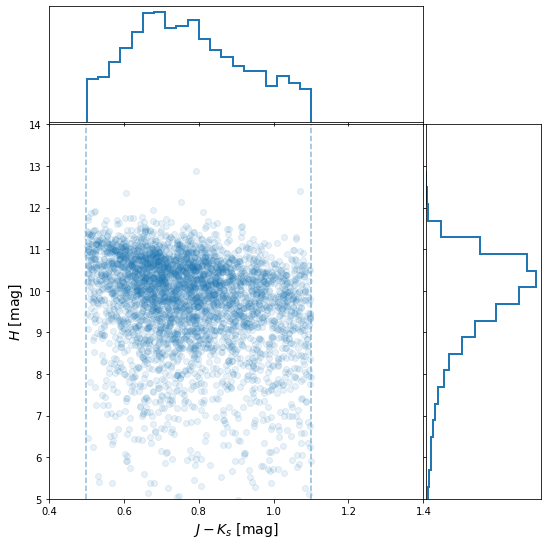

In [106]:
x_values = sliced_tmass_data.j_m - sliced_tmass_data.k_m
y_values = sliced_tmass_data.h_m


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x_values[:: 1000],y_values[:: 1000], ax, ax_histx, ax_histy)

plt.show()